# Projet 4 — Analyse RH : départs d'employés (Attrition)

Objectif : construire un **DataFrame central** (SIRH + Évaluations + Sondage), faire une **EDA** claire, puis entraîner un modèle de classification pour **expliquer / prédire** le départ (`a_quitte_l_entreprise`).  
Je privilégie : **propre, reproductible, sans fuite de données**, et des conclusions actionnables.


## 0) Setup

- Imports
- Réglages d'affichage
- Fonctions utilitaires (nettoyage, checks)


In [54]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer, make_column_selector as selector
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from attrs import validate
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, cross_validate
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score, log_loss, classification_report


import matplotlib.pyplot as plt
import seaborn as sns

import shap
from sklearn.metrics import precision_recall_curve

In [55]:


# Affichage : 2 décimales partout (DataFrames + numpy)
np.set_printoptions(precision=2, suppress=True)
pd.options.display.float_format = "{:,.2f}".format

pd.set_option("display.max_columns", None)
pd.set_option("display.width", 140)

RANDOM_STATE = 42


In [56]:
# Chargement
eval_df = pd.read_csv("src/extrait_eval.csv")
sondage_df = pd.read_csv("src/extrait_sondage.csv")
sirh_df = pd.read_csv("src/extrait_sirh.csv")

print("eval_df:", eval_df.shape)
print("sondage_df:", sondage_df.shape)
print("sirh_df:", sirh_df.shape)

display(eval_df.head(3))
display(sondage_df.head(3))
display(sirh_df.head(3))


eval_df: (1470, 10)
sondage_df: (1470, 12)
sirh_df: (1470, 12)


,satisfaction_employee_environnement,note_evaluation_precedente,niveau_hierarchique_poste,satisfaction_employee_nature_travail,satisfaction_employee_equipe,satisfaction_employee_equilibre_pro_perso,eval_number,note_evaluation_actuelle,heure_supplementaires,augementation_salaire_precedente
0,2,3,2,4,1,1,E_1,3,Oui,11 %
1,3,2,2,2,4,3,E_2,4,Non,23 %
2,4,2,1,3,2,3,E_4,3,Oui,15 %


,a_quitte_l_entreprise,nombre_participation_pee,nb_formations_suivies,nombre_employee_sous_responsabilite,code_sondage,distance_domicile_travail,niveau_education,domaine_etude,ayant_enfants,frequence_deplacement,annees_depuis_la_derniere_promotion,annes_sous_responsable_actuel
0,Oui,0,0,1,1,1,2,Infra & Cloud,Y,Occasionnel,0,5
1,Non,1,3,1,2,8,1,Infra & Cloud,Y,Frequent,1,7
2,Oui,0,3,1,4,2,2,Autre,Y,Occasionnel,0,0


,id_employee,age,genre,revenu_mensuel,statut_marital,departement,poste,nombre_experiences_precedentes,nombre_heures_travailless,annee_experience_totale,annees_dans_l_entreprise,annees_dans_le_poste_actuel
0,1,41,F,5993,Célibataire,Commercial,Cadre Commercial,8,80,8,6,4
1,2,49,M,5130,Marié(e),Consulting,Assistant de Direction,1,80,10,10,7
2,4,37,M,2090,Célibataire,Consulting,Consultant,6,80,7,0,0


## 1) Contrôles rapides & typage

Avant de nettoyer, je regarde :
- types de colonnes
- valeurs manquantes
- cardinalités (utile pour repérer les colonnes à forte fragmentation)


In [57]:
def quick_overview(df: pd.DataFrame, name: str):
    out = pd.DataFrame({
        "dtype": df.dtypes.astype(str),
        "missing": df.isna().sum(),
        "missing_%": (df.isna().mean() * 100).round(2),
        "n_unique": df.nunique(dropna=True),
    })
    print(f"\n=== {name} — overview ===")
    display(out.sort_values(["missing_%","n_unique"], ascending=[False, False]).head(20))

quick_overview(eval_df, "EVAL")
quick_overview(sondage_df, "SONDAGE")
quick_overview(sirh_df, "SIRH")



=== EVAL — overview ===


,dtype,missing,missing_%,n_unique
eval_number,object,0,0.00,1470
augementation_salaire_precedente,object,0,0.00,15
niveau_hierarchique_poste,int64,0,0.00,5
satisfaction_employee_environnement,int64,0,0.00,4
note_evaluation_precedente,int64,0,0.00,4
satisfaction_employee_nature_travail,int64,0,0.00,4
satisfaction_employee_equipe,int64,0,0.00,4
satisfaction_employee_equilibre_pro_perso,int64,0,0.00,4
note_evaluation_actuelle,int64,0,0.00,2
heure_supplementaires,object,0,0.00,2



=== SONDAGE — overview ===


,dtype,missing,missing_%,n_unique
code_sondage,int64,0,0.00,1470
distance_domicile_travail,int64,0,0.00,29
annes_sous_responsable_actuel,int64,0,0.00,18
annees_depuis_la_derniere_promotion,int64,0,0.00,16
nb_formations_suivies,int64,0,0.00,7
domaine_etude,object,0,0.00,6
niveau_education,int64,0,0.00,5
nombre_participation_pee,int64,0,0.00,4
frequence_deplacement,object,0,0.00,3
a_quitte_l_entreprise,object,0,0.00,2



=== SIRH — overview ===


,dtype,missing,missing_%,n_unique
id_employee,int64,0,0.00,1470
revenu_mensuel,int64,0,0.00,1349
age,int64,0,0.00,43
annee_experience_totale,int64,0,0.00,40
annees_dans_l_entreprise,int64,0,0.00,37
annees_dans_le_poste_actuel,int64,0,0.00,19
nombre_experiences_precedentes,int64,0,0.00,10
poste,object,0,0.00,9
statut_marital,object,0,0.00,3
departement,object,0,0.00,3


## 2) Nettoyage ciblé

Règles :
- uniformiser les Oui/Non/Y/N (sans casser les colonnes)
- convertir les pourcentages textuels en float
- préparer les clés de jointure


In [58]:
def normalize_yes_no(s: pd.Series) -> pd.Series:
    # Normalise sans imposer à toutes les colonnes (on applique seulement où pertinent)
    return (s.astype(str)
              .str.strip()
              .str.lower()
              .replace({"oui":"oui","non":"non","y":"oui","n":"non","true":"oui","false":"non"}))

def percent_to_float(s: pd.Series) -> pd.Series:
    # "11 %" -> 11.0
    s2 = s.astype(str).str.replace("%", "", regex=False).str.strip()
    return pd.to_numeric(s2, errors="coerce")

# --- EVAL : clé + %
eval_df = eval_df.copy()
if "eval_number" in eval_df.columns:
    eval_df["id_employee"] = eval_df["eval_number"].astype(str).str.replace("E_", "", regex=False)
    eval_df["id_employee"] = pd.to_numeric(eval_df["id_employee"], errors="coerce").astype("Int64")

# Pourcentage éventuel
for c in eval_df.columns:
    if eval_df[c].dtype == "object" and eval_df[c].astype(str).str.contains("%").any():
        eval_df[c] = percent_to_float(eval_df[c])

# Oui/Non potentiels
for c in eval_df.columns:
    if eval_df[c].dtype == "object":
        vals = set(eval_df[c].dropna().astype(str).str.strip().str.lower().unique().tolist())
        if vals.issubset({"oui","non","y","n","true","false"}):
            eval_df[c] = normalize_yes_no(eval_df[c])

# --- SONDAGE : cible + oui/non
sondage_df = sondage_df.copy()
if "a_quitte_l_entreprise" in sondage_df.columns:
    sondage_df["a_quitte_l_entreprise"] = normalize_yes_no(sondage_df["a_quitte_l_entreprise"])

for c in sondage_df.columns:
    if sondage_df[c].dtype == "object":
        vals = set(sondage_df[c].dropna().astype(str).str.strip().str.lower().unique().tolist())
        if vals.issubset({"oui","non","y","n","true","false"}):
            sondage_df[c] = normalize_yes_no(sondage_df[c])

# --- SIRH : rien de spécifique, mais on évite les espaces
sirh_df = sirh_df.copy()
for c in sirh_df.columns:
    if sirh_df[c].dtype == "object":
        sirh_df[c] = sirh_df[c].astype(str).str.strip()

display(eval_df.head(3))
display(sondage_df.head(3))
display(sirh_df.head(3))


,satisfaction_employee_environnement,note_evaluation_precedente,niveau_hierarchique_poste,satisfaction_employee_nature_travail,satisfaction_employee_equipe,satisfaction_employee_equilibre_pro_perso,eval_number,note_evaluation_actuelle,heure_supplementaires,augementation_salaire_precedente,id_employee
0,2,3,2,4,1,1,E_1,3,oui,11,1
1,3,2,2,2,4,3,E_2,4,non,23,2
2,4,2,1,3,2,3,E_4,3,oui,15,4


,a_quitte_l_entreprise,nombre_participation_pee,nb_formations_suivies,nombre_employee_sous_responsabilite,code_sondage,distance_domicile_travail,niveau_education,domaine_etude,ayant_enfants,frequence_deplacement,annees_depuis_la_derniere_promotion,annes_sous_responsable_actuel
0,oui,0,0,1,1,1,2,Infra & Cloud,oui,Occasionnel,0,5
1,non,1,3,1,2,8,1,Infra & Cloud,oui,Frequent,1,7
2,oui,0,3,1,4,2,2,Autre,oui,Occasionnel,0,0


,id_employee,age,genre,revenu_mensuel,statut_marital,departement,poste,nombre_experiences_precedentes,nombre_heures_travailless,annee_experience_totale,annees_dans_l_entreprise,annees_dans_le_poste_actuel
0,1,41,F,5993,Célibataire,Commercial,Cadre Commercial,8,80,8,6,4
1,2,49,M,5130,Marié(e),Consulting,Assistant de Direction,1,80,10,10,7
2,4,37,M,2090,Célibataire,Consulting,Consultant,6,80,7,0,0


## 3) Jointure — DataFrame central

Clé implicite constatée :
- `sirh_df.id_employee`
- `eval_df.id_employee` dérivé de `eval_number`
- `sondage_df.code_sondage`

Je verrouille la jointure avec des contrôles de doublons pour éviter les surprises.


In [59]:
def assert_unique_key(df: pd.DataFrame, key: str, name: str):
    if key not in df.columns:
        raise KeyError(f"{name}: la clé '{key}' n'existe pas")
    dup = df[key].duplicated().sum()
    if dup > 0:
        raise ValueError(f"{name}: {dup} doublons détectés sur la clé '{key}'. Il faut dédoublonner avant merge.")

# On vérifie (si ça pète, c'est qu'il faut traiter la table concernée)
assert_unique_key(sirh_df, "id_employee", "SIRH")
assert_unique_key(eval_df, "id_employee", "EVAL")
assert_unique_key(sondage_df, "code_sondage", "SONDAGE")

# Merge
df_central = (sirh_df
    .merge(eval_df.drop(columns=[c for c in ["eval_number"] if c in eval_df.columns]),
           on="id_employee", how="left", validate="one_to_one")
    .merge(sondage_df, left_on="id_employee", right_on="code_sondage", how="left", validate="one_to_one")
)

print("df_central:", df_central.shape)
display(df_central.head(3))


df_central: (1470, 33)


,id_employee,age,genre,revenu_mensuel,statut_marital,departement,poste,nombre_experiences_precedentes,nombre_heures_travailless,annee_experience_totale,annees_dans_l_entreprise,annees_dans_le_poste_actuel,satisfaction_employee_environnement,note_evaluation_precedente,niveau_hierarchique_poste,satisfaction_employee_nature_travail,satisfaction_employee_equipe,satisfaction_employee_equilibre_pro_perso,note_evaluation_actuelle,heure_supplementaires,augementation_salaire_precedente,a_quitte_l_entreprise,nombre_participation_pee,nb_formations_suivies,nombre_employee_sous_responsabilite,code_sondage,distance_domicile_travail,niveau_education,domaine_etude,ayant_enfants,frequence_deplacement,annees_depuis_la_derniere_promotion,annes_sous_responsable_actuel
0,1,41,F,5993,Célibataire,Commercial,Cadre Commercial,8,80,8,6,4,2,3,2,4,1,1,3,oui,11,oui,0,0,1,1,1,2,Infra & Cloud,oui,Occasionnel,0,5
1,2,49,M,5130,Marié(e),Consulting,Assistant de Direction,1,80,10,10,7,3,2,2,2,4,3,4,non,23,non,1,3,1,2,8,1,Infra & Cloud,oui,Frequent,1,7
2,4,37,M,2090,Célibataire,Consulting,Consultant,6,80,7,0,0,4,2,1,3,2,3,3,oui,15,oui,0,3,1,4,2,2,Autre,oui,Occasionnel,0,0


## 4) EDA rapide (focus attrition)

Je regarde :
- stats descriptives globales
- répartition de la cible
- quelques comparaisons Restés vs Partis


In [60]:
plt.style.use("seaborn-v0_8-whitegrid")


In [61]:
# Répartition de la cible
target_col = "a_quitte_l_entreprise"
if target_col not in df_central.columns:
    raise KeyError(f"Cible '{target_col}' absente du df_central.")

df_central[target_col].value_counts(dropna=False)


a_quitte_l_entreprise
non    1233
oui     237
Name: count, dtype: int64

In [62]:
# Quelques stats numériques
display(df_central.select_dtypes(include=[np.number]).describe().T.head(15))


,count,mean,std,min,25%,50%,75%,max
id_employee,"1,470.00","1,024.87",602.02,1.00,491.25,"1,020.50","1,555.75","2,068.00"
age,"1,470.00",36.92,9.14,18.00,30.00,36.00,43.00,60.00
revenu_mensuel,"1,470.00","6,502.93","4,707.96","1,009.00","2,911.00","4,919.00","8,379.00","19,999.00"
nombre_experiences_precedentes,"1,470.00",2.69,2.50,0.00,1.00,2.00,4.00,9.00
nombre_heures_travailless,"1,470.00",80.00,0.00,80.00,80.00,80.00,80.00,80.00
annee_experience_totale,"1,470.00",11.28,7.78,0.00,6.00,10.00,15.00,40.00
annees_dans_l_entreprise,"1,470.00",7.01,6.13,0.00,3.00,5.00,9.00,40.00
annees_dans_le_poste_actuel,"1,470.00",4.23,3.62,0.00,2.00,3.00,7.00,18.00
satisfaction_employee_environnement,"1,470.00",2.72,1.09,1.00,2.00,3.00,4.00,4.00
note_evaluation_precedente,"1,470.00",2.73,0.71,1.00,2.00,3.00,3.00,4.00


In [63]:
# Comparaison Restés vs Partis (si possible)
df_central[target_col] = normalize_yes_no(df_central[target_col])
df_partis = df_central[df_central[target_col] == "oui"].copy()
df_restes = df_central[df_central[target_col] != "oui"].copy()

print("Restés:", len(df_restes), "| Partis:", len(df_partis))


Restés: 1233 | Partis: 237


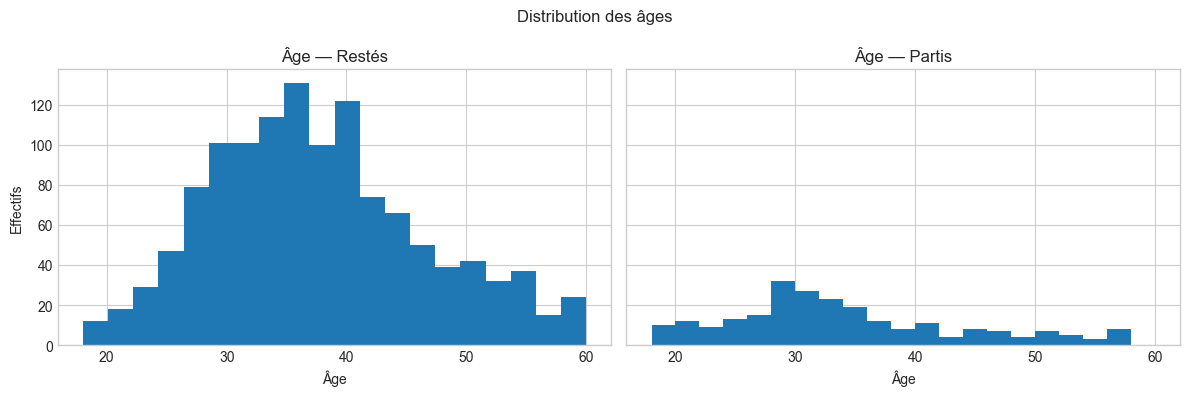

In [64]:
# 4.1 Histogramme âge (side by side)
if "age" in df_central.columns:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,4), sharex=True, sharey=True)
    ax1.hist(df_restes["age"].dropna(), bins=20)
    ax1.set_title("Âge — Restés"); ax1.set_xlabel("Âge"); ax1.set_ylabel("Effectifs")

    ax2.hist(df_partis["age"].dropna(), bins=20)
    ax2.set_title("Âge — Partis"); ax2.set_xlabel("Âge")
    plt.suptitle("Distribution des âges")
    plt.tight_layout(); plt.show()


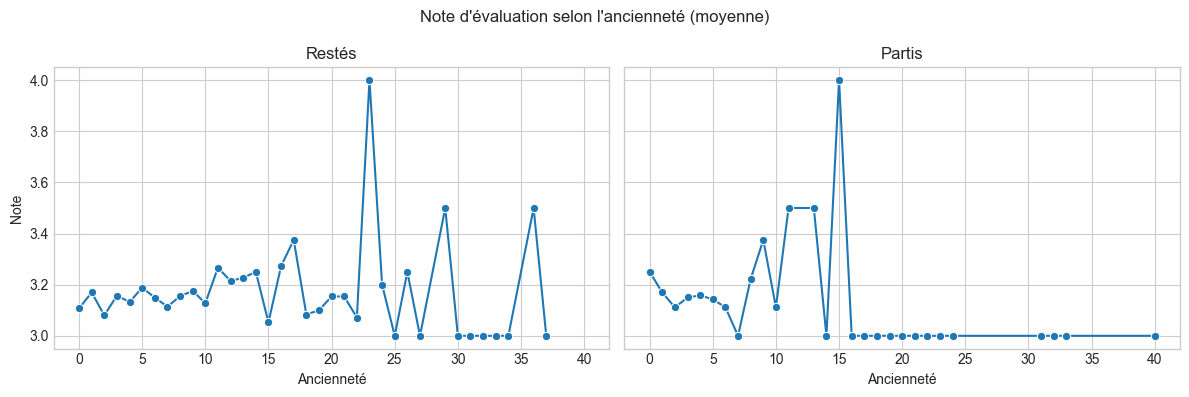

In [65]:
# 4.2 Ancienneté vs note (courbe de moyenne)
x_col = "annees_dans_l_entreprise"
y_col = "note_evaluation_actuelle"

if x_col in df_central.columns and y_col in df_central.columns:
    m_restes = df_restes.groupby(x_col)[y_col].mean().reset_index()
    m_partis = df_partis.groupby(x_col)[y_col].mean().reset_index()

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,4), sharex=True, sharey=True)
    sns.lineplot(data=m_restes, x=x_col, y=y_col, marker="o", ax=ax1)
    ax1.set_title("Restés"); ax1.set_xlabel("Ancienneté"); ax1.set_ylabel("Note")

    sns.lineplot(data=m_partis, x=x_col, y=y_col, marker="o", ax=ax2)
    ax2.set_title("Partis"); ax2.set_xlabel("Ancienneté")
    plt.suptitle("Note d'évaluation selon l'ancienneté (moyenne)")
    plt.tight_layout(); plt.show()


C:\Users\mouto\AppData\Local\Temp\ipykernel_10720\3434572230.py:8: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax1.boxplot(data_restes, labels=genres, showfliers=False)
C:\Users\mouto\AppData\Local\Temp\ipykernel_10720\3434572230.py:11: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax2.boxplot(data_partis, labels=genres, showfliers=False)


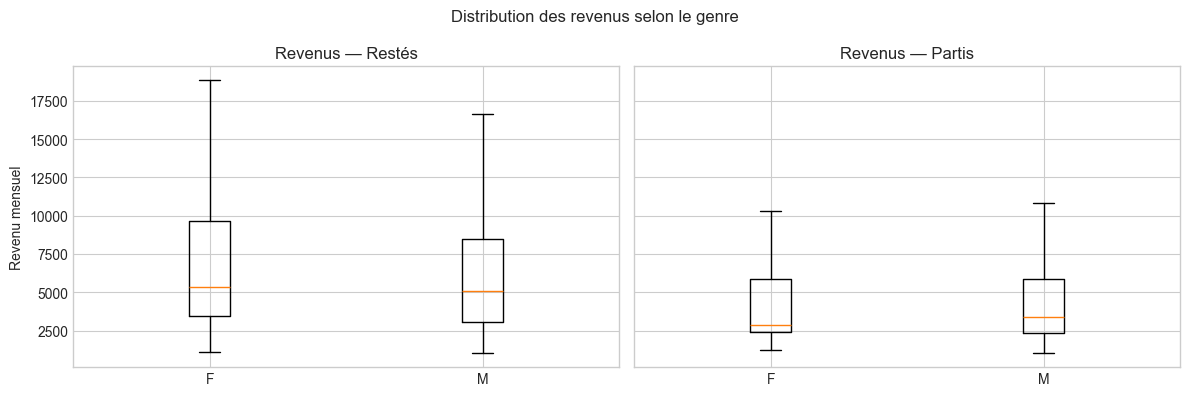

In [66]:
# 4.3 Revenus selon genre (side by side boxplot)
if "genre" in df_central.columns and "revenu_mensuel" in df_central.columns:
    genres = sorted(set(df_central["genre"].dropna().unique()), key=lambda x: str(x))
    data_restes = [df_restes[df_restes["genre"]==g]["revenu_mensuel"].dropna().values for g in genres]
    data_partis = [df_partis[df_partis["genre"]==g]["revenu_mensuel"].dropna().values for g in genres]

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,4), sharey=True)
    ax1.boxplot(data_restes, labels=genres, showfliers=False)
    ax1.set_title("Revenus — Restés"); ax1.set_ylabel("Revenu mensuel")

    ax2.boxplot(data_partis, labels=genres, showfliers=False)
    ax2.set_title("Revenus — Partis")
    plt.suptitle("Distribution des revenus selon le genre")
    plt.tight_layout(); plt.show()


## 5) Modélisation — Pipeline sans fuite

Règles :
- la cible est retirée de X
- les identifiants techniques sont droppés (sinon sur-apprentissage)
- preprocessing dans un Pipeline (imputation + encodage + scaling)


In [67]:
# --- X / y
y = df_central[target_col].copy()
y = y.astype(str).str.strip().str.lower().map({"oui":1, "non":0, "y":1, "n":0, "true":1, "false":0})

# Nettoyage rapide : on garde uniquement lignes où y est défini
mask = y.notna()
df_model = df_central.loc[mask].copy()
y = y.loc[mask].astype(int)

# Colonnes à drop (IDs / fuites évidentes)
cols_drop = [c for c in ["id_employee", "code_sondage", "eval_number"] if c in df_model.columns]
X = df_model.drop(columns=cols_drop + [target_col], errors="ignore")

# Split stratifié
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y
)

print("Train:", X_train.shape, "Test:", X_test.shape)
y_train.value_counts(normalize=True), y_test.value_counts(normalize=True)


Train: (1176, 30) Test: (294, 30)


(a_quitte_l_entreprise
 0   0.84
 1   0.16
 Name: proportion, dtype: float64,
 a_quitte_l_entreprise
 0   0.84
 1   0.16
 Name: proportion, dtype: float64)

In [68]:
# Preprocessing "projet" : Imputer + Scale + OneHot
numeric_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer([
    ("num", numeric_pipe, selector(dtype_include=np.number)),
    ("cat", categorical_pipe, selector(dtype_exclude=np.number)),
])

pipe = Pipeline([
    ("prep", preprocessor),
    ("clf", LogisticRegression(max_iter=2000, class_weight="balanced"))
])


In [90]:
# Baseline : Logistic Regression uniquement
scores = cross_validate(
    pipe,
    X_train,
    y_train,
    cv=cv,
    scoring=scoring
)

baseline_results = {
    "Model": "LogisticRegression_baseline",
    "F1_mean": scores["test_f1"].mean(),
    "ROC_AUC_mean": scores["test_roc_auc"].mean()
}

baseline_df = pd.DataFrame([baseline_results])

baseline_df.round(2)

,Model,F1_mean,ROC_AUC_mean
0,LogisticRegression_baseline,0.50,0.83


## 6) Validation croisée (sur le train)

Je fais la CV sur le train uniquement.  
Le test reste mon hold-out final, pour une mesure honnête en fin de notebook.


In [69]:
models = {
    "RandomForest": RandomForestClassifier(n_estimators=300, random_state=RANDOM_STATE),
    "XGBoost": XGBClassifier(n_estimators=300, learning_rate=0.05,
                             random_state=RANDOM_STATE, eval_metric="logloss"),
    "LightGBM": LGBMClassifier(n_estimators=300, learning_rate=0.05,
                               random_state=RANDOM_STATE),
    "LogisticRegression": LogisticRegression(max_iter=2000, class_weight="balanced")
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
scoring = {"f1": "f1", "roc_auc": "roc_auc"}

results = []

for name, model in models.items():
    pipe = Pipeline([
        ("prep", preprocessor),
        ("clf", model)
    ])
    
    scores = cross_validate(
        pipe, X_train, y_train,
        cv=cv, scoring=scoring
    )
    
    results.append({
        "Model": name,
        "F1_mean": scores["test_f1"].mean(),
        "ROC_AUC_mean": scores["test_roc_auc"].mean()
    })

results_df = pd.DataFrame(results).sort_values("F1_mean", ascending=False)
results_df.round(3)


[LightGBM] [Info] Number of positive: 152, number of negative: 788
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000092 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 585
[LightGBM] [Info] Number of data points in the train set: 940, number of used features: 47
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.161702 -> initscore=-1.645618
[LightGBM] [Info] Start training from score -1.645618
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 152, number of negative: 789
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000097 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[Light

,Model,F1_mean,ROC_AUC_mean
3,LogisticRegression,0.50,0.83
2,LightGBM,0.50,0.81
1,XGBoost,0.46,0.81
0,RandomForest,0.34,0.82


In [70]:
best_name = results_df.sort_values("F1_mean", ascending=False).iloc[0]["Model"]
best_model = models[best_name]

pipe = Pipeline([
    ("prep", preprocessor),
    ("clf", best_model)
])

print("Modèle retenu :", best_name, "|", type(best_model))


Modèle retenu : LogisticRegression | <class 'sklearn.linear_model._logistic.LogisticRegression'>


## 7) Évaluation finale sur le test

Ici je fit sur tout le train, puis je score une seule fois sur le test.


In [92]:
pipe.fit(X_train, y_train)

proba_test = pipe.predict_proba(X_test)[:, 1]
pred_test = (proba_test >= 0.5).astype(int)

acc = accuracy_score(y_test, pred_test)
f1 = f1_score(y_test, pred_test, zero_division=0)
prec = precision_score(y_test, pred_test, zero_division=0)
rec = recall_score(y_test, pred_test, zero_division=0)
auc = roc_auc_score(y_test, proba_test)
ll = log_loss(y_test, np.clip(proba_test, 1e-6, 1-1e-6))


print(f"F1 test       : {f1:.2f}")
print(f"Accuracy test : {acc:.2f}")
print(f"Precision test: {prec:.2f}")
print(f"Recall test   : {rec:.2f}")
print(f"ROC-AUC test  : {auc:.2f}")
print(f"LogLoss test  : {ll:.2f}\n")

print(classification_report(y_test, pred_test, digits=3))


F1 test       : 0.48
Accuracy test : 0.77
Precision test: 0.38
Recall test   : 0.68
ROC-AUC test  : 0.81
LogLoss test  : 0.47

              precision    recall  f1-score   support

           0      0.928     0.785     0.851       247
           1      0.376     0.681     0.485        47

    accuracy                          0.769       294
   macro avg      0.652     0.733     0.668       294
weighted avg      0.840     0.769     0.792       294



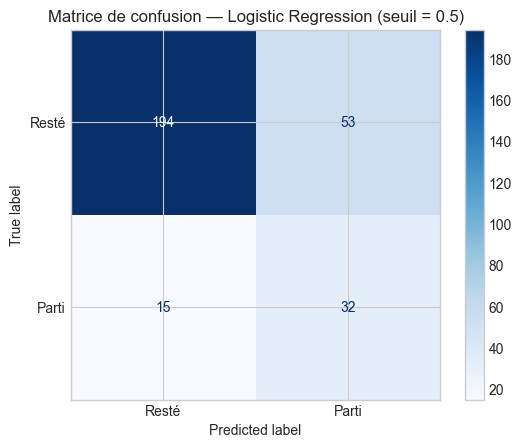

In [72]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

# Probabilités et prédictions (seuil 0.5)
proba_test = pipe.predict_proba(X_test)[:, 1]
y_pred = (proba_test >= 0.5).astype(int)

# Matrice de confusion
cm = confusion_matrix(y_test, y_pred)

# Affichage graphique
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=["Resté", "Parti"]
)

disp.plot(cmap="Blues", values_format="d")
plt.title("Matrice de confusion — Logistic Regression (seuil = 0.5)")
plt.show()


## 8) (Option) Seuil optimal pour F1

Si l'objectif métier est de mieux capter les départs (rappel) sans exploser les faux positifs, je règle le seuil.


In [73]:

# --- 1) Calcul du meilleur seuil sur le TRAIN (pas sur le test) ---
proba_train = pipe.predict_proba(X_train)[:, 1]

p, r, th = precision_recall_curve(y_train, proba_train)
th = np.r_[0, th]  # aligner tailles
f1s = 2 * p * r / (p + r + 1e-12)

best_i = np.nanargmax(f1s)
best_th = th[best_i]

print(f"Meilleur seuil (F1 max sur train) : {best_th:.2f}")
print(f"F1 train à ce seuil : {f1s[best_i]:.2f} | Precision : {p[best_i]:.2f} | Recall : {r[best_i]:.2f}")

# --- 2) Application du seuil au TEST (évaluation honnête) ---
proba_test = pipe.predict_proba(X_test)[:, 1]
pred_test_best = (proba_test >= best_th).astype(int)

print("\nRapport classification (test, seuil fixé sur train)")
print(classification_report(y_test, pred_test_best, digits=3))
print("F1 test (seuil optimisé):", f1_score(y_test, pred_test_best).round(3))

Meilleur seuil (F1 max sur train) : 0.74
F1 train à ce seuil : 0.64 | Precision : 0.71 | Recall : 0.58

Rapport classification (test, seuil fixé sur train)
              precision    recall  f1-score   support

           0      0.889     0.939     0.913       247
           1      0.545     0.383     0.450        47

    accuracy                          0.850       294
   macro avg      0.717     0.661     0.682       294
weighted avg      0.834     0.850     0.839       294

F1 test (seuil optimisé): 0.45


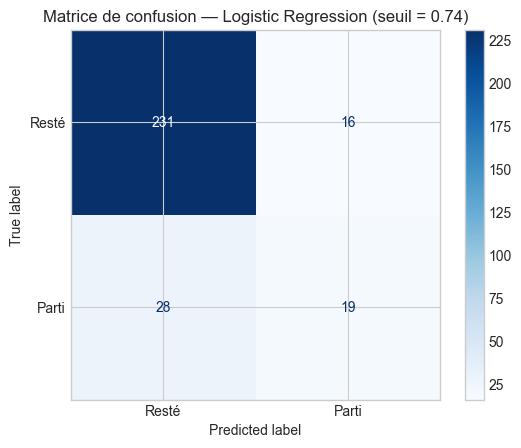

In [95]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

# Probabilités et prédictions (seuil 0.5)
proba_test = pipe.predict_proba(X_test)[:, 1]
y_pred = (proba_test >= 0.74).astype(int)

# Matrice de confusion
cm = confusion_matrix(y_test, y_pred)

# Affichage graphique
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=["Resté", "Parti"]
)

disp.plot(cmap="Blues", values_format="d")
plt.title("Matrice de confusion — Logistic Regression (seuil = 0.74)")
plt.show()


## 9) SHAP — Explication du modèle (LogisticRegression)

Je reste cohérent : j'explique le **modèle final** (celui utilisé pour scorer).  
Comme c'est un modèle linéaire, j'utilise `shap.LinearExplainer`.


In [75]:
# Transformation des données train via le préprocesseur du pipeline
X_train_proc = pipe.named_steps["prep"].transform(X_train)

# Récupération des noms de features après OneHot / scaling
feature_names = pipe.named_steps["prep"].get_feature_names_out()

# Conversion en DataFrame (gestion sparse si besoin)
X_train_proc_df = pd.DataFrame(
    X_train_proc.toarray() if hasattr(X_train_proc, "toarray") else X_train_proc,
    columns=feature_names,
    index=X_train.index
)

X_train_proc_df.head()

,num__age,num__revenu_mensuel,num__nombre_experiences_precedentes,num__nombre_heures_travailless,num__annee_experience_totale,num__annees_dans_l_entreprise,num__annees_dans_le_poste_actuel,num__satisfaction_employee_environnement,num__note_evaluation_precedente,num__niveau_hierarchique_poste,num__satisfaction_employee_nature_travail,num__satisfaction_employee_equipe,num__satisfaction_employee_equilibre_pro_perso,num__note_evaluation_actuelle,num__augementation_salaire_precedente,num__nombre_participation_pee,num__nb_formations_suivies,num__nombre_employee_sous_responsabilite,num__distance_domicile_travail,num__niveau_education,num__annees_depuis_la_derniere_promotion,num__annes_sous_responsable_actuel,cat__genre_F,cat__genre_M,cat__statut_marital_Célibataire,cat__statut_marital_Divorcé(e),cat__statut_marital_Marié(e),cat__departement_Commercial,cat__departement_Consulting,cat__departement_Ressources Humaines,cat__poste_Assistant de Direction,cat__poste_Cadre Commercial,cat__poste_Consultant,cat__poste_Directeur Technique,cat__poste_Manager,cat__poste_Représentant Commercial,cat__poste_Ressources Humaines,cat__poste_Senior Manager,cat__poste_Tech Lead,cat__heure_supplementaires_non,cat__heure_supplementaires_oui,cat__domaine_etude_Autre,cat__domaine_etude_Entrepreunariat,cat__domaine_etude_Infra & Cloud,cat__domaine_etude_Marketing,cat__domaine_etude_Ressources Humaines,cat__domaine_etude_Transformation Digitale,cat__ayant_enfants_oui,cat__frequence_deplacement_Aucun,cat__frequence_deplacement_Frequent,cat__frequence_deplacement_Occasionnel
1194,1.09,2.03,1.33,0.00,2.26,-0.67,-0.63,-0.66,1.80,1.76,-0.65,0.24,0.34,-0.43,-0.34,2.61,-0.61,0.00,-0.90,1.06,-0.37,-0.62,1.00,0.00,0.00,1.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,1.00
128,-1.63,-0.86,-1.08,0.00,-1.07,-0.83,-0.91,0.26,0.37,-0.99,1.15,0.24,0.34,-0.43,-0.34,0.25,-0.61,0.00,-0.90,-1.86,-0.06,-0.90,0.00,1.00,0.00,0.00,1.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,1.00
810,0.98,2.35,0.12,0.00,1.49,0.81,1.34,-1.58,0.37,1.76,0.25,1.16,0.34,-0.43,-0.88,0.25,0.19,0.00,-0.78,-1.86,0.57,1.35,0.00,1.00,0.00,0.00,1.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,1.00
478,-1.31,-0.96,-0.68,0.00,-0.56,-0.01,-0.06,-0.66,0.37,-0.99,0.25,0.24,0.34,-0.43,-1.15,-0.94,-1.40,0.00,0.45,-1.86,-0.68,0.51,0.00,1.00,0.00,0.00,1.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,1.00,0.00,0.00,1.00
491,0.65,-0.19,0.12,0.00,-0.18,0.16,0.78,1.18,0.37,-0.07,0.25,-0.68,0.34,-0.43,-0.61,0.25,0.19,0.00,-0.04,2.04,0.57,0.79,0.00,1.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,1.00,1.00,0.00,1.00,0.00


C:\Users\mouto\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\shap\explainers\_linear.py:99: FutureWarning: The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, maskers.Partition or maskers.Impute).
  warnings.warn(wmsg, FutureWarning)


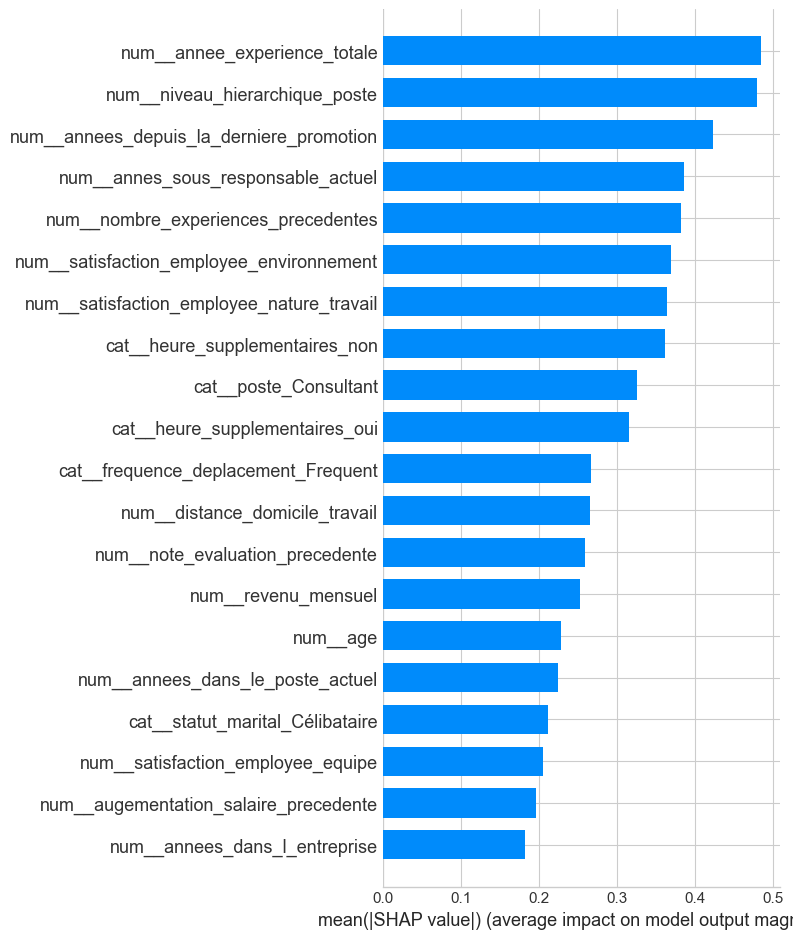

In [76]:
model = pipe.named_steps["clf"]

# --- Choix automatique de l'explainer selon le type de modèle ---
if hasattr(model, "coef_"):  # modèle linéaire (LogReg, Ridge, etc.)
    explainer = shap.LinearExplainer(model, X_train_proc_df, feature_perturbation="interventional")
    shap_values = explainer(X_train_proc_df)

    shap.summary_plot(shap_values, X_train_proc_df, plot_type="bar")

else:  # modèles arbres (LightGBM, XGBoost, RandomForest…)
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X_train_proc_df)

    # Cas binaire → shap_values peut être une liste
    if isinstance(shap_values, list):
        shap_values = shap_values[1]

    shap.summary_plot(shap_values, X_train_proc_df, plot_type="bar")


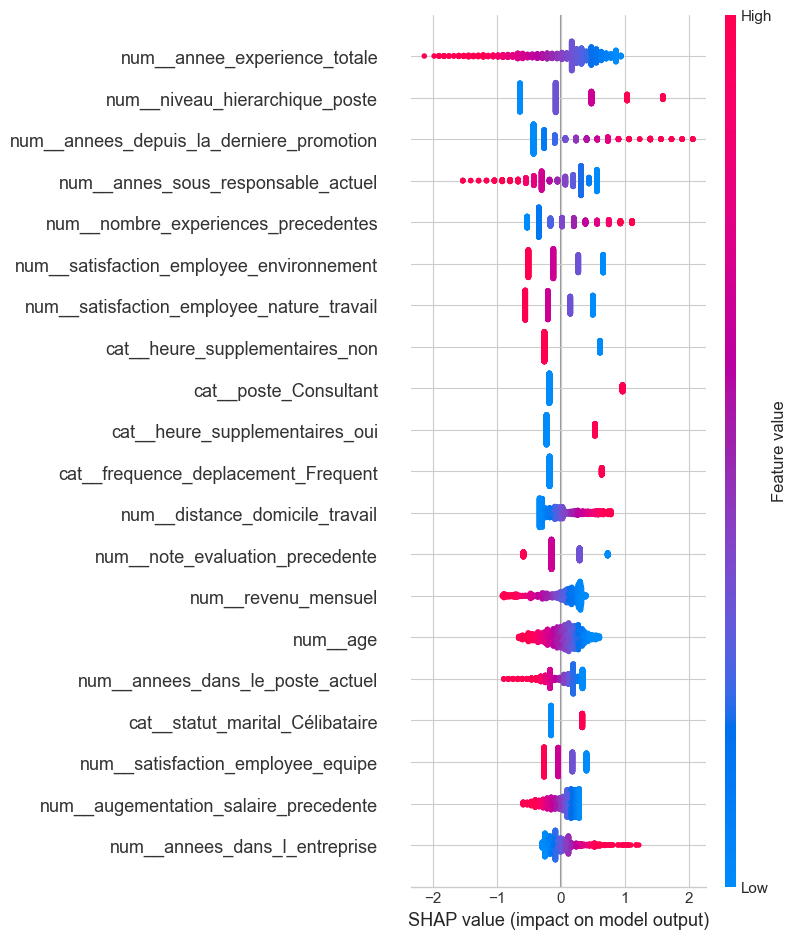

In [77]:
# Vue détaillée (beeswarm)
shap.summary_plot(shap_values, X_train_proc_df)


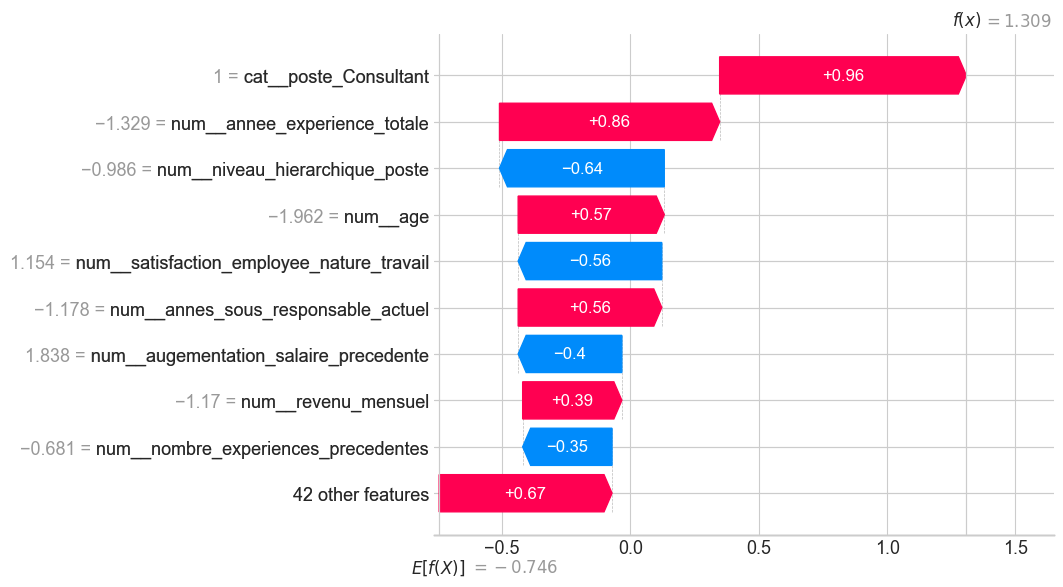

In [78]:
i = 15  # index à expliquer

if hasattr(shap_values, "values"):  
    # Cas LinearExplainer (déjà un objet Explanation)
    shap.plots.waterfall(shap_values[i])

else:
    # Cas TreeExplainer (array brut)
    shap.plots.waterfall(
        shap.Explanation(
            values=shap_values[i],
            base_values=explainer.expected_value[1]
            if isinstance(explainer.expected_value, (list, np.ndarray))
            else explainer.expected_value,
            data=X_train_proc_df.iloc[i],
            feature_names=X_train_proc_df.columns
        )
    )


## Conclusion (à compléter)

- Performance stable en CV (moyenne + écart-type)
- Score test final
- Variables les plus influentes (SHAP) : à commenter en 5 lignes max
